In [1]:
from selenium.webdriver.common.by import By
from selenium.webdriver.remote.webelement import WebElement

import cv2
import time

In [2]:
import sys
sys.path.insert(0, '..')

from web_interaction.main import open_game, start_game, wait_loading, insert_user_stories_from_image
from web_interaction.main import fill_game_main_info_from_image
from web_interaction.main import apply_decompose_action, apply_user_story_action
from game.game import ProductOwnerGame
from environment.backlog_env import BacklogEnv
from environment.environment import ProductOwnerEnv
from environment.reward_sytem.base_reward_system import BaseRewardSystem
from environment.userstory_env import UserstoryEnv

from pipeline.study_agent import load_dqn_agent

In [3]:
agent = load_dqn_agent('../models/credit_start_model.pt')

In [4]:
driver = open_game()

iframe = driver.find_element(by=By.ID, value='game_drop')

In [5]:
# open full screen
fullscreen_button = driver.find_element(by=By.CLASS_NAME, value="fullscreen_btn")
fullscreen_button.click()

In [6]:
height = iframe.rect["height"]  # 540 or 1028
width = iframe.rect["width"]  # 960 or 1920

In [7]:
wait_loading(iframe)

start_game(driver, iframe)

In [8]:
iframe.screenshot('game_state.png')

image = cv2.imread('game_state.png')

In [9]:
class EmptyColorStorage:
    def __init__(self) -> None:
        pass

    def get_unused_color(self, uc_type):
        pass

    def release_color(self, us_type, color):
        pass

In [10]:
game = ProductOwnerGame()
context = game.context

context.is_new_game = False
game.is_first_release = False
game.userstories.disable_restrictions()
game.office.toggle_purchases(True)

available_developers_count = 2
current_rooms_counter = 1
blank_sprint_counter = 0

game.context.color_storage = EmptyColorStorage()

In [11]:
insert_user_stories_from_image(game, image)

game.userstories.stories_list

[S l:0.035 c:3.0]

In [12]:
fill_game_main_info_from_image(game, image)

print('Sprint', game.context.current_sprint)
print('Sprint hours', game.context.current_sprint_hours)
print('Money', game.context.get_money())
print('Loyalty', game.context.get_loyalty())
print('Customers', game.context.customers)
print('Credit', game.context.credit)

Sprint 4.0
Sprint hours 0
Money 33000.0
Loyalty 4.0
Customers 25.0
Credit 273000.0


In [13]:
userstory_env = UserstoryEnv(4, 0, 0)
backlog_env = BacklogEnv(12, 0, 0, 0, 0, 0)
reward_system = BaseRewardSystem(config={})
env = ProductOwnerEnv(userstory_env, backlog_env, with_info=True, reward_system=reward_system)
env.game = game

In [14]:
from web_interaction.main import (
    apply_start_sprint_action,
    apply_release_action,
    apply_buy_statistical_research_action,
    apply_backlog_card_action
)


def apply_web_action(action: int, driver, iframe: WebElement, env: ProductOwnerEnv):
    if action == 0:  # start sprint

        apply_start_sprint_action(driver, iframe, width, height, env)

        return

    if action == 1:  # decompose

        apply_decompose_action(driver, iframe, width, height, env)

        return

    if action == 2:  # release

        apply_release_action(driver, iframe, width, height, env)

        return

    if action == 5:  # buy statistical research

        apply_buy_statistical_research_action(driver, iframe, env)

        return

    if action >= env.meta_action_dim:

        action -= env.meta_action_dim

    if action < env.userstory_env.max_action_num:

        apply_user_story_action(action, driver, iframe, env)

        return

    action -= env.userstory_env.max_action_num

    if action < env.backlog_env.backlog_max_action_num:

        apply_backlog_card_action(action, driver, iframe, env)

        return

    raise Exception(f"Unknown action: {action}")

In [17]:
while not game.context.done:
    state = env.recalculate_state()
    # print(state)

    info = env.get_info()
    # print(info)

    action = agent.get_action(state, info)
    # print(action)

    time.sleep(1)
    apply_web_action(action, driver, iframe, env)

    if env.game.context.current_sprint >= 35:
        break

Start moving backlog card
Selected card Hours: 16.0, Color: frozenset({(1, 79), (0, 120), (2, 240)}), Label: S, Type: UserCardType.S
Found at position (1472, 349)
Clicked on card
Start new sprint
Start moving backlog card
Selected card Hours: 7.0, Color: frozenset({(1, 79), (0, 120), (2, 240)}), Label: S, Type: UserCardType.S
Found at position (1559, 349)
Clicked on card
Start moving backlog card
Selected card Hours: 9.0, Color: frozenset({(1, 79), (0, 120), (2, 240)}), Label: S, Type: UserCardType.S
Found at position (1559, 349)
Clicked on card
Start user story action: 3


IndexError: list index out of range

Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint


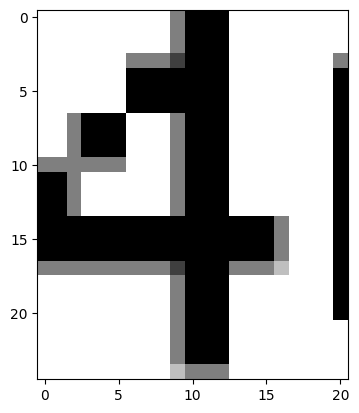

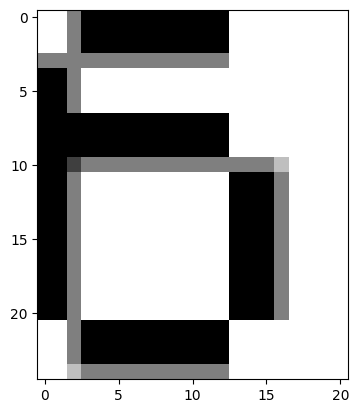

KeyboardInterrupt: Interrupted by user

In [ ]:
while not game.context.done:
    time.sleep(1)
    apply_web_action(0, driver, iframe, env)

In [ ]:
iframe.rect

In [ ]:
driver.quit()